# EDA数据探索性分析
在此对数据进行初步处理

测试pytorch

In [69]:
import torch

print(f"PyTorch 版本: {torch.__version__}")
# Define device
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print("使用的设备是：", device)

PyTorch 版本: 2.7.0+cu128
使用的设备是： cuda


创建必要目录

In [70]:
import os
base_dirs = [
    '../data/raw',
    '../data/processed',
    '../data/processed/ERA5'
]
for d in base_dirs:
    os.makedirs(d,exist_ok=True)
    print(f"已创建或存在:{d}")

已创建或存在:../data/raw
已创建或存在:../data/processed
已创建或存在:../data/processed/ERA5


基本数据导入测试与可视化

============= Open dataset... =============
<xarray.Dataset> Size: 4MB
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    sst        (latitude, longitude) float32 4MB ...
数据维度: (721, 1440)
数据范围: <xarray.DataArray 'sst' ()> Size: 4B
array(270.18765, dtype=float32) 到 <xarray.DataArray 'sst' ()> Size: 4B
array(306.92264, dtype=float32)
坐标: Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
变量: Frozen({'longitude': <xarray.IndexVariable 'longitude' (longitude: 1440)> Size: 6kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Attributes:
    units:      degrees_east
    long_name:  longitude, 'latitude': <xarray.IndexVariable 'latitude

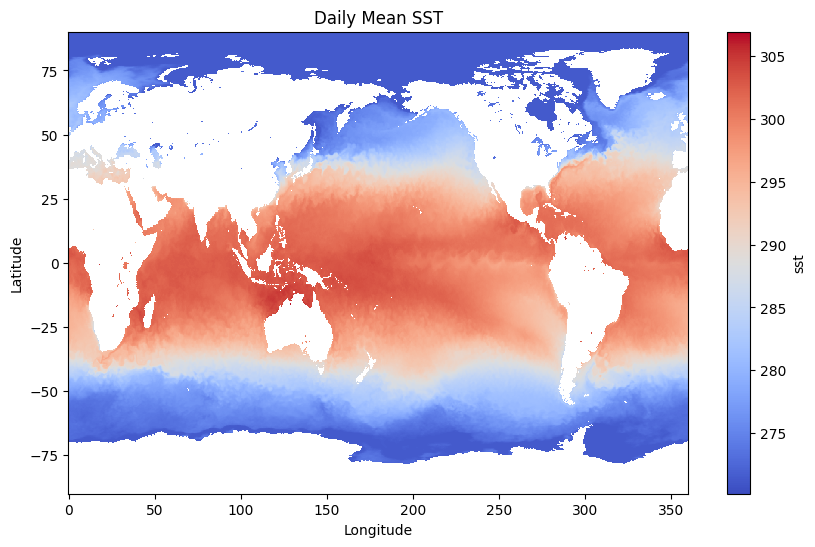

In [71]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("============= Open dataset... =============")
root_path = '../data/raw/ERA5/'
date = '20200101' # from 20200101 to 20200331
ds = xr.open_dataset(root_path + date + '_ERA5_daily_mean_sst.nc')

print(ds)

# 检查数据维度
print(f"数据维度: {ds.sst.shape}")

# 检查数据范围
print(f"数据范围: {ds.sst.min()} 到 {ds.sst.max()}")

# 检查坐标
print(f"坐标: {ds.coords}")

# 检查变量
print(f"变量: {ds.variables}")

# 可视化
plt.figure(figsize=(10, 6))
ds['sst'].plot(cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Daily Mean SST')
plt.show()




## 数据预处理

采取了文档中的思路一：保持完整数据

1.数据合并

============= 数据预处理 =============
开始加载每日数据...
已经加载20200101到20200131中，共31天数据。
开始沿时间维度合并数据...
合并后的数据集
<xarray.Dataset> Size: 129MB
Dimensions:    (time: 31, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 248B 2020-01-01 2020-01-02 ... 2020-01-31
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    sst        (time, latitude, longitude) float32 129MB 271.5 271.5 ... nan nan


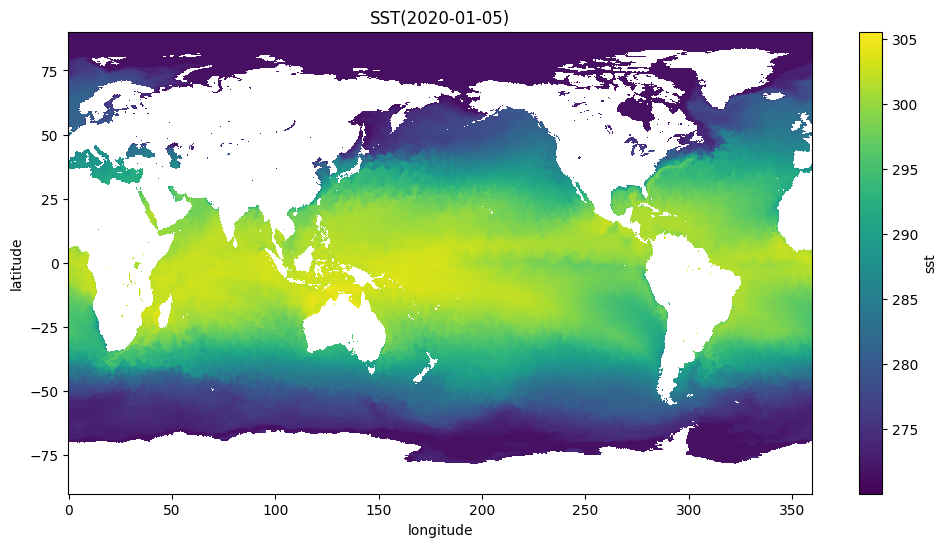

In [72]:

print("============= 数据预处理 =============")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# 基础参数
root_path = '../data/raw/ERA5/'
start_date_str = '20200101' 
end_date_str = '20200131'
save_era5_dir = '../data/processed/ERA5/' # 保存处理后的数据路径


## 变量名
temp_var_name = 'sst'
lat_coord_name = 'latitude'
lon_coord_name = 'longitude'
time_coord_name = 'time' # 合并数据需要考虑时间维度

## 日期生成
date_to_load = pd.date_range(start=start_date_str,end=end_date_str,freq='D').strftime('%Y%m%d')

list_of_datasets = []
actual_loaded_dates = []

print("开始加载每日数据...")

for date_str in date_to_load:
    
    filename = f"{date_str}_ERA5_daily_mean_sst.nc"

    # 取出变量并添加时间维度
    daily_ds = xr.open_dataset(root_path+filename).expand_dims(dim={time_coord_name: [pd.to_datetime(date_str)]})
    
    # 加入列表
    list_of_datasets.append(daily_ds[temp_var_name]) # 温度变量
    actual_loaded_dates.append(pd.to_datetime(date_str)) # 日期

print(f"已经加载{start_date_str}到{end_date_str}中，共{len(list_of_datasets)}天数据。")



print("开始沿时间维度合并数据...")  
# 创建时间坐标
time_coordinate = pd.Index(actual_loaded_dates, name=time_coord_name)
# 使用 concat 和 assign_coords 来合并并添加时间坐标
combined_sst_data_array = xr.concat(list_of_datasets, dim=time_coordinate)
# 将 DataArray 转换回 Dataset
ds_combined = combined_sst_data_array.to_dataset(name=temp_var_name)

print(f"合并后的数据集") 
print(ds_combined)# date,lat,lon 

## 检查一个切片
time_index_for_plot = 4
one_date_combined = ds_combined[temp_var_name].isel({time_coord_name:time_index_for_plot})
plt.figure(figsize=(12,6))
one_date_combined.plot()
plt.title(f"SST({pd.to_datetime(str(one_date_combined[time_coord_name].values)).strftime('%Y-%m-%d')})")
plt.xlabel(lon_coord_name)
plt.ylabel(lat_coord_name)
plt.show()


1.2 海洋掩码

开始创建海洋掩码...
海洋mask:
<xarray.DataArray 'ocean_mask' (latitude: 721, longitude: 1440)> Size: 8MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    time       datetime64[ns] 8B 2020-01-01
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0


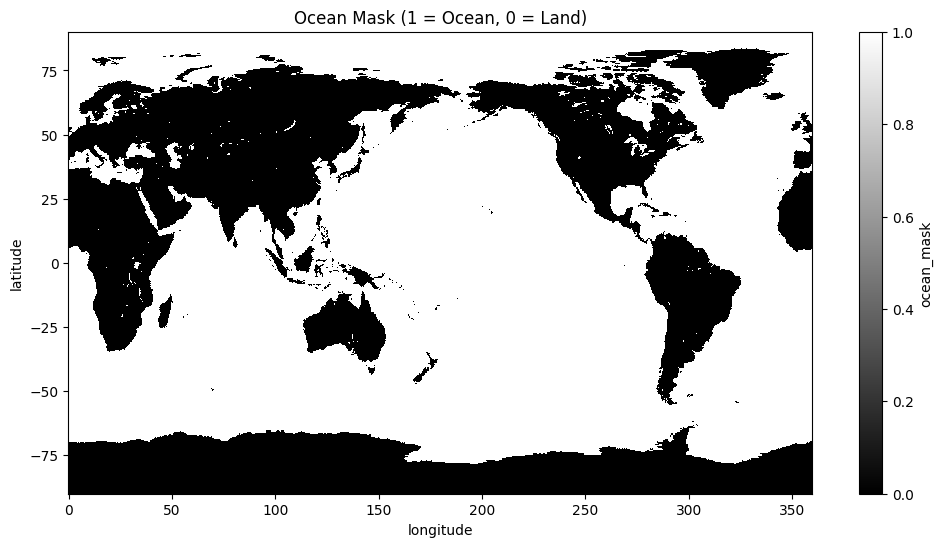

海洋点count = 686364
陆地点count = 351876
保存数据至../data/processed/ERA5/...
保存成功。


In [73]:

print("开始创建海洋掩码...")    
ocean_mask = None
data_for_mask_creation = ds_combined[temp_var_name].isel({time_coord_name:0})  # 基于第一个时间的数据创建即可
ocean_mask = (~data_for_mask_creation.isnull()).astype(int) # ocean -> 1, land -> 0
ocean_mask.name = "ocean_mask"
print("海洋mask:")
print(ocean_mask)

plt.figure(figsize=(12,6))
ocean_mask.plot(cmap='gray')
plt.title('Ocean Mask (1 = Ocean, 0 = Land)')
plt.xlabel(lon_coord_name)
plt.ylabel(lat_coord_name)
plt.show()

print(f"海洋点count = {ocean_mask.sum().item()}")
print(f"陆地点count = {ocean_mask.size - ocean_mask.sum().item()}")



print(f"保存数据至{save_era5_dir}...")
ds_combined.to_netcdf(os.path.join(save_era5_dir,f"ERA5_{start_date_str}_{end_date_str}.nc"))
print("保存成功。")

1.3 填充NaN

先按照简单的填充方式

使用插值方法，沿着lan,lon插值
method = 'linear'

开始NaN值填充...
lat_coord_name' 不是单调递增的。需要对其进行反转...
lat是否单调递增： True
开始对调整坐标后的 SST 数据进行插值填充NaN...


插值后剩余的 NaN 值数量：2839383，剩余的 NaN 将会在归一化被0填充


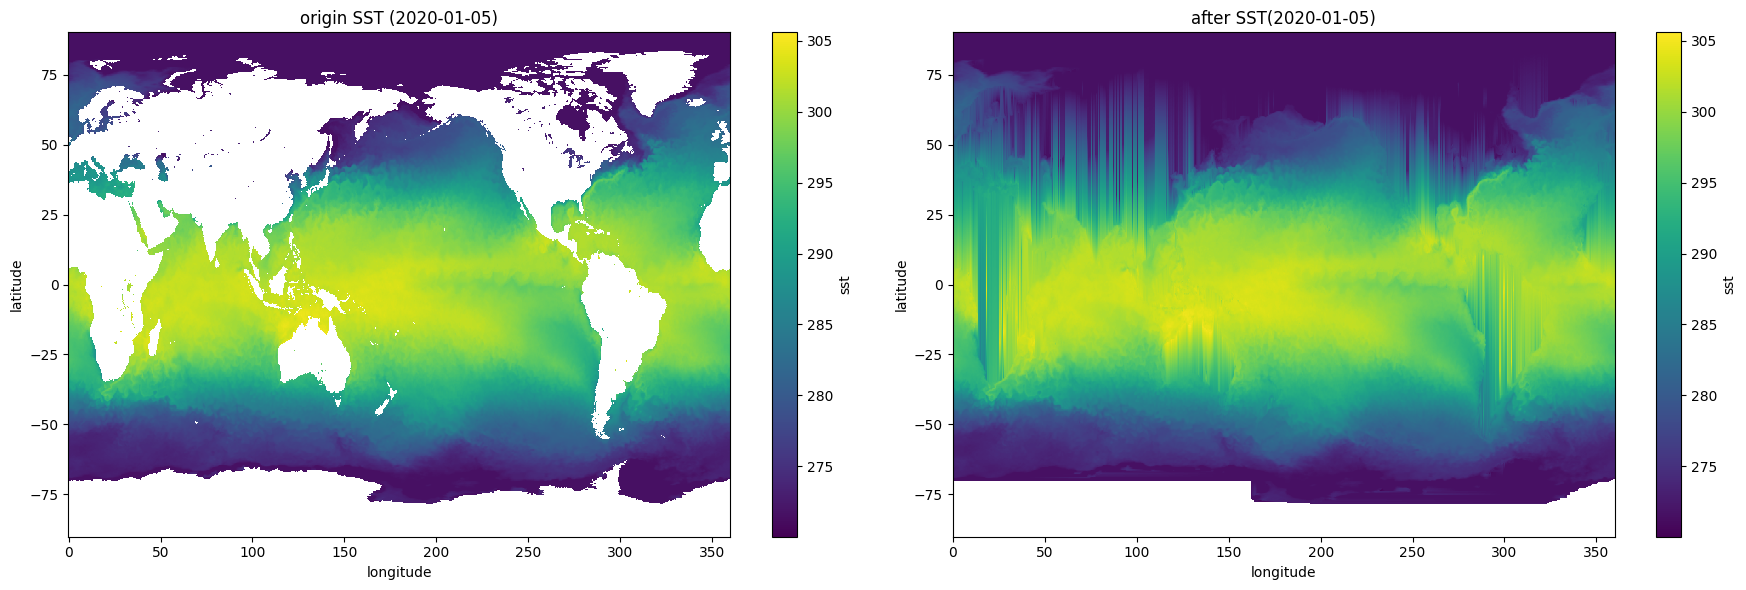

In [74]:
print("开始NaN值填充...")

sst_data_array = ds_combined[temp_var_name] # DataArray,dim = (time,lat,lon)

# TODO:lat是递减的，lon是递增的，通过如下方式先检查
if not sst_data_array[lat_coord_name].to_index().is_monotonic_increasing:
    print(f"lat_coord_name' 不是单调递增的。需要对其进行反转...")
if not sst_data_array[lon_coord_name].to_index().is_monotonic_increasing:
    print(f"lon_coord_name' 不是单调递增的。需要对其进行反转...")


## 反转维度,对于sst,mask都要执行
sst_data_array_for_interp = sst_data_array.isel({lat_coord_name:slice(None,None,-1)})
ocean_mask_for_interp = ocean_mask.isel({lat_coord_name:slice(None,None,-1)})

## 检查
print("lat是否单调递增：",sst_data_array_for_interp[lat_coord_name].to_index().is_monotonic_increasing)

# --- 现在使用坐标调整后的数据进行插值 ---
print("开始对调整坐标后的 SST 数据进行插值填充NaN...")
filled_slices = []
for t_idx in range(len(sst_data_array_for_interp[time_coord_name])):
    slice_to_fill = sst_data_array_for_interp.isel({time_coord_name:t_idx})
    # 分别沿两个维度插值
    filled_slice_lat = slice_to_fill.interpolate_na(dim=lat_coord_name,method='linear')
    fileled_slice_lonlat = filled_slice_lat.interpolate_na(dim=lon_coord_name,method='linear')
    filled_slices.append(fileled_slice_lonlat)

sst_filled_da = xr.concat(filled_slices,dim=time_coord_name)
sst_filled_da.name = temp_var_name

## 检查
remaining_nan_count = np.isnan(sst_filled_da.values).sum()
print(f"插值后剩余的 NaN 值数量：{remaining_nan_count}，剩余的 NaN 将会在归一化被0填充")

## 可视化对比
original_slice_for_plot = sst_data_array_for_interp.isel({time_coord_name: time_index_for_plot})
filled_slice_for_plot = sst_filled_da.isel({time_coord_name: time_index_for_plot})

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
original_slice_for_plot.plot(ax=axes[0])
axes[0].set_title(f"origin SST ({pd.to_datetime(str(original_slice_for_plot[time_coord_name].values)).strftime('%Y-%m-%d')})")
axes[0].set_xlabel(lon_coord_name)
axes[0].set_ylabel(lat_coord_name)

filled_slice_for_plot.plot(ax=axes[1])
axes[1].set_title(f"after SST({pd.to_datetime(str(filled_slice_for_plot[time_coord_name].values)).strftime('%Y-%m-%d')})")
axes[1].set_xlabel(lon_coord_name)
axes[1].set_ylabel(lat_coord_name)
plt.tight_layout()
plt.show()

1.4 数据归一化处理

在这里直接使用上一步调整lat(递增)进行归一化。需要注意的是，我们使用的mean,std是基于原本sst计算出来的（不包括插值后的数据）

数据归一化开始...
海洋区域 SST 全局均值: 287.1428
海洋区域 SST 全局标准差: 11.5919


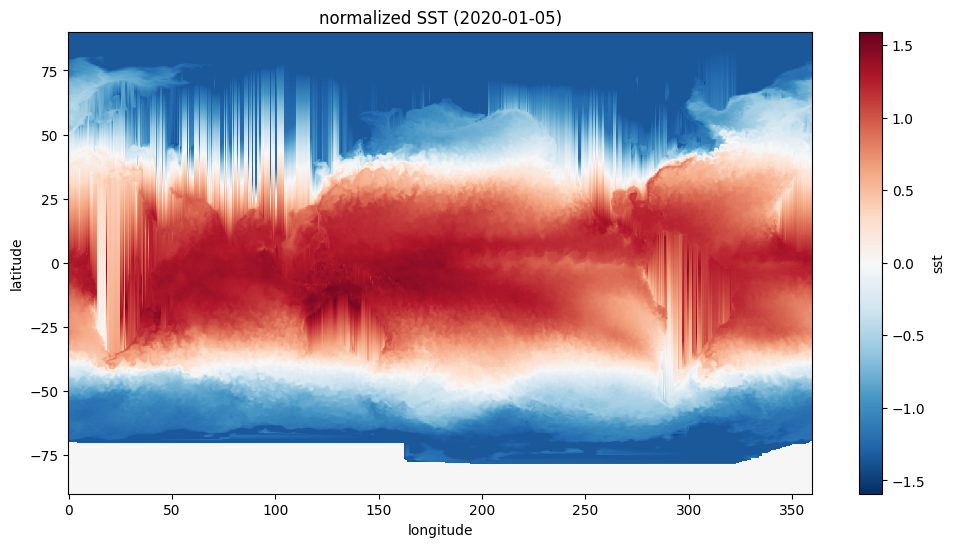

保存处理好的数据...
latitude经过调整为递增顺序
保存完毕。


In [75]:
print("数据归一化开始...")
sst_ocean_for_stats = sst_filled_da.where(ocean_mask_for_interp == 1)


mean_sst_ocean = sst_ocean_for_stats.mean().item()
std_sst_ocean = sst_ocean_for_stats.std().item()

print(f"海洋区域 SST 全局均值: {mean_sst_ocean:.4f}")
print(f"海洋区域 SST 全局标准差: {std_sst_ocean:.4f}")

sst_norm_da = (sst_filled_da - mean_sst_ocean) / std_sst_ocean

## 对归一化后的nan填充0
if remaining_nan_count > 0:
    sst_norm_da = sst_norm_da.fillna(0)

## 可视化
norm_slice = sst_norm_da.isel({time_coord_name:time_index_for_plot})
plt.figure(figsize=(12,6))
norm_slice.plot()
plt.title(f"normalized SST ({pd.to_datetime(str(norm_slice[time_coord_name].values)).strftime('%Y-%m-%d')})")
plt.xlabel(lon_coord_name)
plt.ylabel(lat_coord_name)
plt.show()

## 记录数据

normalization_stats = {
    'variable': temp_var_name,
    'mean': mean_sst_ocean,
    'std': std_sst_ocean
}

print("保存处理好的数据...\nlatitude经过调整为递增顺序")
processed_ds = xr.Dataset({
    temp_var_name:sst_norm_da,
    'ocean_mask':ocean_mask_for_interp
})
processed_ds.to_netcdf(os.path.join(save_era5_dir,f"ERA5_{start_date_str}_{end_date_str}_normalized_filled_masked.nc"))
print("保存完毕。")

1.5 时间特征提取与处理

提取时间特征，年归一化，周期性编码(time encoding)

In [76]:
print("开始时间特征提取与处理...\n")

time_coordinate = processed_ds[time_coord_name]

## 提取时间
day_of_year = time_coordinate.dt.dayofyear
year = time_coordinate.dt.year
month = time_coordinate.dt.month


print(f"原始 年份: {year.values[:5]}...") # 显示前5个值
print(f"原始 年积日: {day_of_year.values[:5]}...")
print(f"原始 月份: {month.values[:5]}...")

# 归一化与周期性编码
days_in_year = xr.where(time_coordinate.dt.is_leap_year,366.0,365.0)
doy_norm = (day_of_year - 1) / (days_in_year)

## Day of Year
doy_sin = np.sin(2 * np.pi * doy_norm)
doy_cos = np.cos(2 * np.pi * day_of_year)
doy_sin.name = 'doy_sin'
doy_cos.name = 'doy_cos'
# print(doy_sin)

## Month
month_sin = np.sin(2 * np.pi * month / 12.0)
month_cos = np.cos(2 * np.pi * month / 12.0)
month_sin.name = 'month_sin'
month_cos.name = 'month_cos'
# print(month_sin)

## Year 这里没有周期性不用做三角变换 
## TODO:如果多年的数据就不可以简单这样做了
year_norm = (year - 2000) / 20.0
year_norm.name = 'year_norm'
# print(year_norm)


processed_ds[doy_sin.name] = doy_sin
processed_ds[doy_cos.name] = doy_cos
processed_ds[month_sin.name] = month_sin
processed_ds[month_cos.name] = month_cos
processed_ds[year_norm.name] = year_norm

print("\n--- 加入时间特征后的dataset ---")
print(processed_ds)

# 保存包含时间特征dataset
processed_with_timefeatures_path = os.path.join(save_era5_dir, f"ERA5_{start_date_str}_{end_date_str}_normalized_filled_masked_timefeatures.nc")
processed_ds.to_netcdf(processed_with_timefeatures_path)
print(f"\n包含时间特征的最终数据已保存到: {processed_with_timefeatures_path}")

开始时间特征提取与处理...

原始 年份: [2020 2020 2020 2020 2020]...
原始 年积日: [1 2 3 4 5]...
原始 月份: [1 1 1 1 1]...

--- 加入时间特征后的dataset ---
<xarray.Dataset> Size: 137MB
Dimensions:     (time: 31, longitude: 1440, latitude: 721)
Coordinates:
  * time        (time) datetime64[ns] 248B 2020-01-01 2020-01-02 ... 2020-01-31
  * longitude   (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude    (latitude) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    sst         (time, latitude, longitude) float32 129MB 0.0 0.0 ... -1.353
    ocean_mask  (latitude, longitude) int64 8MB 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    doy_sin     (time) float64 248B 0.0 0.01717 0.03433 ... 0.4624 0.4775 0.4925
    doy_cos     (time) float64 248B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    month_sin   (time) float64 248B 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    month_cos   (time) float64 248B 0.866 0.866 0.866 ... 0.866 0.866 0.866
    year_norm   (time) float64 248B 1.0 1.0 1.0 

## 构建pytorch Dataset, DataLoader

2.1 OceanDataSet类

In [77]:
import torch 
from torch.utils.data import Dataset,DataLoader

class OceanDataSet(Dataset):
    def __init__(self,nc_file_path,sst_var_name='sst',mask_var_name='ocean_mask',time_coord='time',time_feature_names=None):
        """
        Args:
            nc_file_path (str): Path to the processed NetCDF file.
            sst_var_name (str): Name of the SST variable in the NetCDF file.
            mask_var_name (str): Name of the ocean mask variable.
            time_coord (str): Name of the time coordinate.
            time_feature_names (list of str, optional): List of time feature variable names to load.If None, no additional time features are loaded.
        """
        super().__init__()
        self.nc_file_path = nc_file_path
        self.sst_var_name = sst_var_name
        self.mask_var_name = mask_var_name
        self.time_coord = time_coord
        self.time_feature_names = time_feature_names

        print(f"从：{nc_file_path} 加载数据")
        with xr.open_dataset(self.nc_file_path) as ds:
            self.sst_data = ds[self.sst_var_name].load() #(time,lat,lon)
            self.ocean_mask = ds[self.mask_var_name].load() #(lat,lon)
            self.time_features_data = {} # time feature
            for feature_name in self.time_feature_names:
                if feature_name in ds:
                    self.time_features_data[feature_name] = ds[feature_name].load()
                else:
                    print(f"warning: 时间特征{feature_name} 未在文件中找到。")
            self.num_timestep = len(ds[self.time_coord])
            self.latitudes = ds[self.sst_data.dims[1]].values
            self.longtitudes = ds[self.sst_data.dims[2]].values

        print(f"数据加载完成，共{self.num_timestep}个时间步。")
        print(f"SST data\n{self.sst_data}")
        print(f"Ocean Mask data\n{self.ocean_mask}")
        if self.time_feature_names:
            print(f"加载的时间特征{list(self.time_features_data.keys())}")

    def __len__(self):
        """ 返回样本数量(number of timestep)"""
        return self.num_timestep
    
    def __getitem__(self, idx):
        """
        根据idx(time_coord)返回一个样本
        返回一个dist,包含SST图像，海洋掩码和条件特征(time embedding)
        """
        # SST 数据需要转换为tensor[C,H,W]形状
        sst_slice_np = self.sst_data.isel({self.time_coord:idx}).data # to numpy
        sst_tensor = torch.from_numpy(sst_slice_np).float().unsqueeze(0) # 添加通道C=1 -> [1,H,W]

        # Ocean Mask 数据转化为tensor
        mask_tensor = torch.from_numpy(self.ocean_mask.data).float().unsqueeze(0)

        # 条件特征条件特征(time embedding),并转化为tensor
        conditional_features_list = []
        for feature_name in self.time_feature_names:
            if feature_name in self.time_features_data:
                feature_value = self.time_features_data[feature_name].isel({self.time_coord:idx}).item()
                conditional_features_list.append(feature_value)

        conditional_features_tensor = torch.tensor(conditional_features_list,dtype=torch.float32)
        
        return {
            'sst': sst_tensor,                     # 形状: [1, H, W]
            'ocean_mask': mask_tensor,             # 形状: [1, H, W]
            'conditions': conditional_features_tensor # 形状: [num_time_features]
        }
        

2.2 创建DataLoader

In [79]:
processed_nc_file = processed_with_timefeatures_path # 数据处理完后的文件

# 变量名，需要和NetCDF中的变量名一样
time_features_to_use = [
    'doy_sin','doy_cos',
    'month_sin','month_cos',
    'year_norm' # 实际上这里在小规模数据上没必要 TODO:放在大规模数据这里要考虑
]

print("开始创建 DataSet 和 DataLoader")

ocean_dataset = OceanDataSet(
    nc_file_path=processed_nc_file,
    sst_var_name=temp_var_name,
    mask_var_name='ocean_mask',
    time_coord=time_coord_name,
    time_feature_names=time_features_to_use
)

########## 训练设置区域 ###########

batch_size = 5
num_workers = 0 # Windows下建议为0，Linux下可以设为 >0 的值以加速数据加载，例如 2 或 4
shuffle_data = True # 训练时通常需要打乱数据

##################################

ocean_dataloader = DataLoader(
    ocean_dataset,
    batch_size=batch_size,
    shuffle=shuffle_data,
    num_workers=num_workers,
    pin_memory=False  # 如果使用GPU，pin_memory可以加速数据传输
)

print(f"\nDataLoader 创建成功。批次大小: {batch_size}, 是否打乱: {shuffle_data}\n")

## 测试DataLoader,迭代几个batch检查

for i,batch in enumerate(ocean_dataloader):
    sst_batch = batch[temp_var_name]
    mask_batch = batch['ocean_mask']
    conditions_batch = batch['conditions']

    print(f"\n批次 {i+1}:")
    print(f"  SST 批次形状: {sst_batch.shape}")       # 期望: [batch_size, 1, H, W]
    print(f"  掩码批次形状: {mask_batch.shape}")     # 期望: [batch_size, 1, H, W]
    print(f"  条件批次形状: {conditions_batch.shape}") # 期望: [batch_size, num_time_features]

    if i>=0 :
        break # 先只测试一个
    
        

开始创建 DataSet 和 DataLoader
从：../data/processed/ERA5/ERA5_20200101_20200131_normalized_filled_masked_timefeatures.nc 加载数据
数据加载完成，共31个时间步。
SST data
<xarray.DataArray 'sst' (time: 31, latitude: 721, longitude: 1440)> Size: 129MB
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [-1.3528693, -1.3528693, -1.3528693, ..., -1.3528693,
         -1.3528693, -1.3528693],
        [-1.3528693, -1.3528693, -1.3528693, ..., -1.3528693,
         -1.3528693, -1.3528693],
        [-1.3528693, -1.3528693, -1.3528693, ..., -1.3528693,
         -1.3528693, -1.3528693]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.  

## 构建Diffusion Model

3.1 基础U-Net架构

源于：arXiv:1505.04597 这个最经典的架构

In [80]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """  (Convolution => [BN] => ReLU) * 2 + Time/Condition Embedding"""
    def __init__(self,in_channels,out_channels,mid_channels=None,use_groupnorm=True,num_groups=32,
                 time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.time_emb_dim = time_emb_dim
        self.cond_emb_dim = cond_emb_dim
        total_emb_dim = 0

        if self.time_emb_dim is not None:
            self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, mid_channels))
            total_emb_dim += mid_channels
        if self.cond_emb_dim is not None:
            self.cond_mlp = nn.Sequential(nn.SiLU(), nn.Linear(cond_emb_dim, mid_channels))
            total_emb_dim += mid_channels

        # 如果有任何一种嵌入，创建一个MLP将它们（或它们的组合）映射到第一个卷积的输出通道
        # 为了简化，我们这里分别处理，并在卷积后相加

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(min(num_groups, mid_channels), mid_channels) if use_groupnorm else nn.BatchNorm2d(mid_channels)
        self.act1 = nn.SiLU(inplace=True)

        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(min(num_groups, out_channels), out_channels) if use_groupnorm else nn.BatchNorm2d(out_channels)
        self.act2 = nn.SiLU(inplace=True)

        # 线性层将嵌入投影到与卷积输出相同的通道数，以便相加
        if self.time_emb_dim is not None:
            self.time_proj1 = nn.Linear(time_emb_dim, mid_channels)
        if self.cond_emb_dim is not None:
            self.cond_proj1 = nn.Linear(cond_emb_dim, mid_channels)

        #  TODO:（可选）第二个卷积后的投影
        # 为了简化，我们只在第一个卷积后注入
        # if self.time_emb_dim is not None:
        #     self.time_proj2 = nn.Linear(time_emb_dim, out_channels)
        # if self.cond_emb_dim is not None:
        #     self.cond_proj2 = nn.Linear(cond_emb_dim, out_channels)

    def forward(self, x, t_emb=None, c_emb=None): # 接收时间步和条件嵌入
        h = self.conv1(x)
        h = self.norm1(h)

        # 注入时间嵌入
        if t_emb is not None and self.time_emb_dim is not None:
            t_emb_proj = self.time_proj1(F.silu(t_emb)) # [B, mid_channels]
            h = h + t_emb_proj.unsqueeze(-1).unsqueeze(-1) # Reshape to [B, mid_channels, 1, 1] for broadcasting

        # 注入上下文条件嵌入
        if c_emb is not None and self.cond_emb_dim is not None:
            c_emb_proj = self.cond_proj1(F.silu(c_emb)) # [B, mid_channels]
            h = h + c_emb_proj.unsqueeze(-1).unsqueeze(-1) # Reshape to [B, mid_channels, 1, 1]

        h = self.act1(h)

        h2 = self.conv2(h)
        h2 = self.norm2(h2)

        # TODO:(可选) 再次注入嵌入到第二个卷积的输出
        # if t_emb is not None and self.time_emb_dim is not None:
        #     t_emb_proj2 = self.time_proj2(F.silu(t_emb))
        #     h2 = h2 + t_emb_proj2.unsqueeze(-1).unsqueeze(-1)
        # if c_emb is not None and self.cond_emb_dim is not None:
        #     c_emb_proj2 = self.cond_proj2(F.silu(c_emb))
        #     h2 = h2 + c_emb_proj2.unsqueeze(-1).unsqueeze(-1)

        h2 = self.act2(h2)
        return h2

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, use_groupnorm=True, time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_channels, out_channels, use_groupnorm=use_groupnorm, 
                                      time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)

    def forward(self, x, t_emb=None, c_emb=None):
        x = self.maxpool(x)
        return self.double_conv(x, t_emb, c_emb)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, use_groupnorm=True, time_emb_dim=None, cond_emb_dim=None):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.cond_emb_dim = cond_emb_dim

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # DoubleConv的in_channels是拼接后的通道数 (x2_channels + x1_up_channels)
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2, 
                                   use_groupnorm=use_groupnorm, time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, use_groupnorm=use_groupnorm,
                                   time_emb_dim=time_emb_dim, cond_emb_dim=cond_emb_dim)


    def forward(self, x1, x2, t_emb=None, c_emb=None): # x1 from upsampling path, x2 from skip connection
        x1 = self.up(x1)
        # 让x1 (H,W) 维度与 x2 一致的padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x, t_emb, c_emb)

class OutConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=1)

    def forward(self,x):
        return self.conv(x)

# 接受时间和条件嵌入的UNet模型
# 每一次上下采样（包括初始卷积、所有 Down 和 Up 模块）都注入了时间嵌入 t_emb 和条件嵌入 c_emb
# 在扩散模型中，这是一个标准做法，用于强化条件信息的传递
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out, time_embedding_dim, cond_embedding_dim, # 新增
                 base_c=64, bilinear=True, use_groupnorm=True):
        super().__init__()
        self.n_channels_in = n_channels_in
        self.n_channels_out = n_channels_out
        self.bilinear = bilinear
        self.time_embedding_dim = time_embedding_dim
        self.cond_embedding_dim = cond_embedding_dim
        self.base_c = base_c

        self.inc = DoubleConv(n_channels_in, base_c, use_groupnorm=use_groupnorm,
                              time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down1 = Down(base_c, base_c * 2, use_groupnorm=use_groupnorm,
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down2 = Down(base_c * 2, base_c * 4, use_groupnorm=use_groupnorm,
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.down3 = Down(base_c * 4, base_c * 8, use_groupnorm=use_groupnorm,
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor, use_groupnorm=use_groupnorm,
                          time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)

        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear, use_groupnorm=use_groupnorm,
                      time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear, use_groupnorm=use_groupnorm,
                      time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear, use_groupnorm=use_groupnorm,
                      time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.up4 = Up(base_c * 2, base_c, bilinear, use_groupnorm=use_groupnorm,
                      time_emb_dim=time_embedding_dim, cond_emb_dim=cond_embedding_dim)
        self.outc = OutConv(base_c, n_channels_out)

    def forward(self, x_in, t_emb, c_emb=None): 
        x1 = self.inc(x_in, t_emb, c_emb)
        x2 = self.down1(x1, t_emb, c_emb)
        x3 = self.down2(x2, t_emb, c_emb)
        x4 = self.down3(x3, t_emb, c_emb)
        x5 = self.down4(x4, t_emb, c_emb)

        x = self.up1(x5, x4, t_emb, c_emb)
        x = self.up2(x, x3, t_emb, c_emb)
        x = self.up3(x, x2, t_emb, c_emb)
        x = self.up4(x, x1, t_emb, c_emb)
        logits = self.outc(x)
        return logits

3.2 时间步编码 sinusoidalTimeEmbedding diffusion model需要知道当前是哪个时间步

In [81]:
import math

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time_steps): # time_steps: 1D tensor of shape (B,)
        device = time_steps.device
        # 生成变化的频率尺度，这和 Transformer 的位置编码公式一致
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        # embeddings shape: (half_dim,)
        
        # time_steps shape: (B,) -> (B, 1) for broadcasting
        # embeddings shape: (half_dim,) -> (1, half_dim) for broadcasting
        embeddings = time_steps.unsqueeze(1) * embeddings.unsqueeze(0)
        # embeddings shape: (B, half_dim)
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # embeddings shape: (B, dim)
        
        # 如果dim是奇数，最后一个维度会被截断，可以补零或确保dim是偶数
        if self.dim % 2 == 1:
            embeddings = F.pad(embeddings, (0,1)) # Pad last dimension by 1

        return embeddings

3.3 条件编码，U-Net集成 接收我们之前准备的上下文条件特征（年积日、月份、年份的sin/cos编码等）

In [82]:
# 使用一个MLP作为embedding
class ConditionalEmbeddingMLP(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, conditions): # conditions: [B, input_dim]
        return self.mlp(conditions) # Output: [B, embed_dim]
class ConditionalEmbeddingMLP(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, conditions): # conditions: [B, input_dim]
        return self.mlp(conditions) # Output: [B, embed_dim]

测试 U-Net with Embeddings

In [83]:
# --- 测试 U-Net with Embeddings ---
# 假设你的SST图像通道为1，预测目标（如噪声）也是1通道
# DataLoader 已准备好 (ocean_dataloader)
# time_features_to_use 已定义 (['doy_sin', ..., 'year_norm'])

try:
    sample_batch = next(iter(ocean_dataloader))
    example_sst_batch = sample_batch['sst']      # Shape: [B, 1, H, W]
    example_conditions_batch = sample_batch['conditions'] # Shape: [B, num_context_features]
    B, C, H, W = example_sst_batch.shape
    num_context_features = example_conditions_batch.shape[1]

    print(f"从DataLoader获取的样本形状: SST B={B}, C={C}, H={H}, W={W}")
    print(f"上下文条件形状: B={B}, N_features={num_context_features}")

    # 1. 时间步编码器
    time_embedding_dim = 128 # 嵌入维度
    time_embed_module = SinusoidalTimeEmbedding(dim=time_embedding_dim)
    example_timesteps = torch.randint(0, 1000, (B,)) # 模拟一个批次的时间步 (0-999)
    t_embeddings = time_embed_module(example_timesteps)
    print(f"时间步嵌入形状: {t_embeddings.shape}")

    # 2. 上下文条件编码器 (如果使用)
    cond_embedding_dim = 128 # 可以与时间步嵌入维度相同或不同
    if num_context_features > 0:
        cond_embed_module = ConditionalEmbeddingMLP(input_dim=num_context_features, embed_dim=cond_embedding_dim)
        c_embeddings = cond_embed_module(example_conditions_batch)
        print(f"上下文条件嵌入形状: {c_embeddings.shape}")
    else:
        cond_embed_module = None
        c_embeddings = None
        print("未使用额外的上下文条件嵌入。")


    # 3. 实例化U-Net
    # 输入通道 C_in = 1 (SST)
    # 输出通道 C_out = 1 (预测的噪声)
    unet_model_conditional = UNet(n_channels_in=C, 
                                  n_channels_out=C, 
                                  time_embedding_dim=time_embedding_dim,
                                  cond_embedding_dim=cond_embedding_dim if num_context_features > 0 else 0, # 传递0如果不使用
                                  base_c=32, 
                                  use_groupnorm=True)
    print("\n条件 U-Net 模型实例化成功。")

    # 模拟一次前向传播
    print(f"输入U-Net的形状 (SST): {example_sst_batch.shape}")
    with torch.no_grad():
        predicted_output = unet_model_conditional(example_sst_batch, t_embeddings, c_embeddings)
    print(f"U-Net 输出形状: {predicted_output.shape}")

    if predicted_output.shape == example_sst_batch.shape:
        print("条件 U-Net 前向传播测试成功，输入输出形状一致！")
    else:
        print("警告：条件 U-Net 输出形状与输入形状不一致！请检查U-Net实现。")

except NameError as e:
    print(f"错误: 某些变量未定义 (例如 'ocean_dataloader')。请确保之前的代码已运行。 {e}")
except Exception as e:
    print(f"测试条件U-Net时发生错误: {e}")

从DataLoader获取的样本形状: SST B=5, C=1, H=721, W=1440
上下文条件形状: B=5, N_features=5
时间步嵌入形状: torch.Size([5, 128])
上下文条件嵌入形状: torch.Size([5, 128])

条件 U-Net 模型实例化成功。
输入U-Net的形状 (SST): torch.Size([5, 1, 721, 1440])
U-Net 输出形状: torch.Size([5, 1, 721, 1440])
条件 U-Net 前向传播测试成功，输入输出形状一致！


## 训练逻辑

4.1 设置训练环境和扩散超参数

In [84]:
import torch
import torch.optim as optim

# 我们之前已经定义了:
# OceanDataset, DataLoader, SinusoidalTimeEmbedding, ConditionalEmbeddingMLP, UNet
# 以及加载了数据和各种参数如 time_features_to_use, temp_var_name 等

# --- 步骤 4.1: 设置训练环境和扩散超参数 ---

# 1. 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {device}")

# 2. 扩散过程超参数 TODO:调整superparameters
T = 200  # 总的扩散步数 (可以调整, 例如 200, 1000)
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)# 线性调度 beta
# 或者使用更高级的调度，例如 cosine schedule，为简单起见，我们先用线性调度

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # \bar{\alpha}_t
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # \bar{\alpha}_{t-1}

# 计算前向过程 q(x_t | x_0) 所需的常数
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# 计算后向过程 q(x_{t-1} | x_t, x_0) 所需的常数 (如果模型预测x0或使用DDIM时会用到)
# posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
# 我们模型直接预测噪声 epsilon，所以暂时不需要这个

print(f"扩散步数 T: {T}")
print(f"Betas 形状: {betas.shape}")
print(f"Alphas_cumprod 形状: {alphas_cumprod.shape}")


# 3. 实例化模型组件
try:
    sample_batch_for_dims = next(iter(ocean_dataloader))
    _B, C_in, H, W = sample_batch_for_dims['sst'].shape
    _num_context_features = sample_batch_for_dims['conditions'].shape[1]
    print(f"SST图像维度: B={_B}, C_in={C_in}, H={H}, W={W}")
    print(f"上下文条件特征数量: {_num_context_features}")
except NameError:
    print("错误: 'ocean_dataloader' 未定义。请先运行数据加载部分。")
    print("将使用预估的维度进行模型初始化。")

# 时间步编码器
time_embedding_dim = 128  # 可以调整
time_embed_module = SinusoidalTimeEmbedding(dim=time_embedding_dim).to(device)

# 上下文条件编码器
cond_embedding_dim = 128 # 可以调整
if _num_context_features > 0:
    cond_embed_module = ConditionalEmbeddingMLP(input_dim=_num_context_features, embed_dim=cond_embedding_dim).to(device)
else:
    cond_embed_module = None # 如果没有上下文条件

# U-Net 模型
# C_out 应该和 C_in 一致，因为我们预测的是和输入图像噪声同形状的噪声
unet_model = UNet(n_channels_in=C_in,
                  n_channels_out=C_in, # 预测噪声，所以输出通道与输入噪声图像通道一致
                  time_embedding_dim=time_embedding_dim,
                  cond_embedding_dim=cond_embedding_dim if _num_context_features > 0 else 0,
                  base_c=32, # 可以根据你的GPU调整，例如32或64
                  use_groupnorm=True).to(device)

print(f"\n模型组件实例化完成并已移至 {device}")
print(f"U-Net 输入通道: {C_in}, 输出通道: {C_in}, 时间嵌入维度: {time_embedding_dim}, 条件嵌入维度: {cond_embedding_dim if _num_context_features > 0 else 'N/A'}")

# 4. 损失函数
# 我们预测的是噪声，所以用 MSELoss 比较预测噪声和真实噪声
loss_fn = nn.MSELoss(reduction='none') # reduction='none' 以便后续应用掩码

# 5. 优化器
learning_rate = 1e-4 # 可以调整
optimizer = optim.AdamW(unet_model.parameters(), lr=learning_rate)

print(f"损失函数和优化器定义完成。学习率: {learning_rate}")

将使用设备: cuda


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


4.2 训练循环

In [47]:
from tqdm import tqdm

print("\n--- 步骤 4.2: 开始训练循环 ---")

num_epochs = 10 # 训练的总轮数 
# 你可能还需要:
# - TensorBoard writer 用于记录日志
# - 模型保存的逻辑
# - 梯度裁剪 (可选)
# - 学习率调度器 (可选)

# 一个提取函数，用于从 alphas_cumprod 中提取特定时间步 t 的值
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    # 从 a 中选择与 t 中每个元素对应的元素
    # out 的形状将是 (batch_size,)
    out = a.gather(-1, t) 
    # 将 out 重塑为 (batch_size, 1, 1, 1) 以便与图像 x_shape ([B, C, H, W]) 进行广播
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


for epoch in range(num_epochs):
    epoch_loss = 0.0
    # 使用 tqdm 包装 DataLoader 以显示进度条 (可选，但推荐)
    for batch_idx, batch in enumerate(tqdm(ocean_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()

        # 1. 获取数据并移至设备
        x0_batch = batch['sst'].to(device)             # 原始SST图像 (已归一化), [B, C, H, W]
        ocean_mask_batch = batch['ocean_mask'].to(device) # 海洋掩码, [B, C, H, W]
        conditions_batch = batch['conditions'].to(device) # 上下文条件, [B, num_context_features]
        
        B, C, H, W = x0_batch.shape

        # 2. 为批次中的每个样本随机采样时间步 t
        # t 的范围应该是 [0, T-1] 对应 betas[0] 到 betas[T-1]
        t = torch.randint(0, T, (B,), device=device).long() # 时间步 t, [B]

        # 3. 生成噪声并计算带噪图像 x_t (前向过程)
        noise_epsilon = torch.randn_like(x0_batch) # 标准正态分布噪声 ε, [B, C, H, W]
        
        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x0_batch.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x0_batch.shape)
        
        xt_batch = sqrt_alphas_cumprod_t * x0_batch + sqrt_one_minus_alphas_cumprod_t * noise_epsilon

        # 4. 获取时间步嵌入和条件嵌入
        time_embeddings = time_embed_module(t) # [B, time_embedding_dim]
        
        if cond_embed_module is not None and conditions_batch.shape[1] > 0:
            condition_embeddings = cond_embed_module(conditions_batch) # [B, cond_embedding_dim]
        else:
            condition_embeddings = None

        # 5. 模型预测噪声
        # unet_model(带噪图像, 时间步嵌入, 条件嵌入)
        predicted_noise_epsilon = unet_model(xt_batch, time_embeddings, condition_embeddings)

        # 6. 计算损失 (仅在海洋区域)
        # loss_fn 是 nn.MSELoss(reduction='none')，返回每个像素的损失
        pixel_wise_loss = loss_fn(predicted_noise_epsilon, noise_epsilon) # [B, C, H, W]
        
        # 应用海洋掩码 (ocean_mask_batch 也是 [B, C, H, W])
        # 我们只关心第一个通道的掩码，如果C>1且掩码是单通道的，需要注意广播
        # 我们的SST和掩码都是单通道的，所以直接相乘即可
        masked_loss = pixel_wise_loss * ocean_mask_batch 
        
        # 计算每个样本的平均损失 (仅在海洋像素上)
        # .sum() 对所有维度求和 (B, C, H, W -> 标量)
        # ocean_mask_batch.sum() 计算总的海洋像素点数量 (在整个批次中)
        # 添加一个小值epsilon避免除以0 (如果某个批次恰好没有海洋点，虽然不太可能)
        loss = masked_loss.sum() / (ocean_mask_batch.sum() + 1e-8) 

        # 7. 反向传播和优化
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if (batch_idx + 1) % 20 == 0: # 每20个批次打印一次日志
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(ocean_dataloader)}], Loss: {loss.item():.6f}")

    avg_epoch_loss = epoch_loss / len(ocean_dataloader)
    print(f"--- Epoch [{epoch+1}/{num_epochs}] 完成 --- 平均损失: {avg_epoch_loss:.6f} ---")

    # (可选) 在每个epoch结束时保存模型
    if (epoch + 1) % 10 == 0: # 每10个epoch保存一次
        model_save_path = os.path.join(save_era5_dir, f"unet_sst_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': unet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
            # 可以保存time_embed_module和cond_embed_module的状态字典，如果它们有可学习参数且不是U-Net的一部分
            'time_embed_module_state_dict': time_embed_module.state_dict(),
            'cond_embed_module_state_dict': cond_embed_module.state_dict() if cond_embed_module else None,
            'T': T, # 保存扩散步数等超参数
            'beta_start': beta_start,
            'beta_end': beta_end,
            'time_embedding_dim': time_embedding_dim,
            'cond_embedding_dim': cond_embedding_dim,
            'unet_base_c': unet_model.base_c, # 假设你在U-Net中保存了这个参数
            'normalization_stats': normalization_stats # 从步骤1.4保存的统计量
        }, model_save_path)
        print(f"模型已保存到: {model_save_path}")

print("训练完成!")


--- 步骤 4.2: 开始训练循环 ---


Epoch 1/10:   0%|          | 0/4 [00:09<?, ?it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
